In [38]:
# Import modules
import numpy as N
import matplotlib.pyplot as P
import matplotlib
import time
import gc
import scipy.integrate as spi
from skimage.measure import find_contours
from math import *
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate

# Import my figure routines
from figure_module import *

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from scipy.interpolate import UnivariateSpline
from scipy import signal


In [39]:
# %%
# Connect patch indices and names
sphere = {0: "A", 1: "B", 2: "C", 3: "D", 4: "N", 5: "S"}

class Sphere:
    A = 0
    B = 1
    C = 2
    D = 3
    N = 4
    S = 5

# Parameters
cfl = 0.7
Nxi = 68
Neta = 68
NH = 3
NG = 1 # Number of ghosts zones
xi_min, xi_max = - N.pi / 4.0, N.pi / 4.0
eta_min, eta_max = - N.pi / 4.0, N.pi / 4.0
dxi = (xi_max - xi_min) / Nxi
deta = (eta_max - eta_min) / Neta

# %%
# Define grids
xi  = N.arange(- NG - int(Nxi / 2), NG + int(Nxi / 2), 1) * dxi
eta = N.arange(- NG - int(Neta / 2), NG + int(Neta / 2), 1) * deta

xiH  = N.arange(- NH - int(Nxi / 2), NH + int(Nxi / 2), 1) * dxi
etaH = N.arange(- NH - int(Neta / 2), NH + int(Neta / 2), 1) * deta

eta_grid, xi_grid = N.meshgrid(eta, xi)
etaH_grid, xiH_grid = N.meshgrid(etaH, xiH)

xi_yee  = xi  + 0.5 * dxi
eta_yee = eta + 0.5 * deta

xiH_yee  = xiH  + 0.5 * dxi
etaH_yee = etaH + 0.5 * deta

# Define fields
Er  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
Br  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

E1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

V1HALO = N.zeros((6, Nxi + 2 * NH, Neta + 2 * NH))
V2HALO = N.zeros((6, Nxi + 2 * NH, Neta + 2 * NH))

Phi = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
En = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
EnE1 = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))


In [40]:
# %%
# Define metric tensor
########

g11d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g12d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g22d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):

        # 0 at (i, j)
        X = N.tan(xi[j])
        Y = N.tan(eta[i])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)

        g11d[i, j, 0] = (C * C * D / (delta * delta))**2
        g22d[i, j, 0] = (C * D * D / (delta * delta))**2
        g12d[i, j, 0] = - X * Y * C * C * D * D / (delta)**4

        # 1 at (i + 1/2, j)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)

        g11d[i, j, 1] = (C * C * D / (delta * delta))**2
        g22d[i, j, 1] = (C * D * D / (delta * delta))**2
        g12d[i, j, 1] = - X * Y * C * C * D * D / (delta)**4

        # 2 at (i, j + 1/2)
        X = N.tan(xi[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)

        g11d[i, j, 2] = (C * C * D / (delta * delta))**2
        g22d[i, j, 2] = (C * D * D / (delta * delta))**2
        g12d[i, j, 2] = - X * Y * C * C * D * D / (delta)**4

        # 3 at (i + 1/2, j + 1/2)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)

        g11d[i, j, 3] = (C * C * D / (delta * delta))**2
        g22d[i, j, 3] = (C * D * D / (delta * delta))**2
        g12d[i, j, 3] = - X * Y * C * C * D * D / (delta)**4

sqrt_det_g = N.sqrt(g11d * g22d - g12d * g12d)

dt = cfl * N.min(1.0 / N.sqrt(g11d / (sqrt_det_g * sqrt_det_g) / (dxi * dxi) + g22d / (sqrt_det_g * sqrt_det_g) / (deta * deta) ))
print("delta t = {}".format(dt))

delta t = 0.009188606855068027


In [41]:
# Single-patch push routines
########

def contra_to_cov_E(patch):
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG + 1
             
    E1d[patch, i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u[patch, i0:i1, j0:j1] + \
                         0.25 * g12d[i0:i1, j0:j1, 1] * (E2u[patch, i0:i1, j0:j1] + N.roll(N.roll(E2u, -1, axis = 1), 1, axis = 2)[patch, i0:i1, j0:j1]
                                                        + N.roll(E2u, -1, axis = 1)[patch, i0:i1, j0:j1] + N.roll(E2u, 1, axis = 2)[patch, i0:i1, j0:j1])

    i0, i1 = NG, Nxi + NG + 1
    j0, j1 = NG, Neta + NG

    E2d[patch, i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u[patch, i0:i1, j0:j1] + \
                         0.25 * g12d[i0:i1, j0:j1, 2] * (E1u[patch, i0:i1, j0:j1] + N.roll(N.roll(E1u, 1, axis = 1), -1, axis = 2)[patch, i0:i1, j0:j1]
                                                        + N.roll(E1u, -1, axis = 2)[patch, i0:i1, j0:j1] + N.roll(E1u, 1, axis = 1)[patch, i0:i1, j0:j1])

    # w1 = sqrt_det_g[i0:i1, j0:j1, 2]
    # w2 = N.roll(N.roll(sqrt_det_g[:, :, 2], -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1]
    # w3 = N.roll(sqrt_det_g[:, :, 2], -1, axis = 0)[i0:i1, j0:j1]
    # w4 = N.roll(sqrt_det_g[:, :, 2], 1, axis = 1)[i0:i1, j0:j1]
    
    # E1d[patch, i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u[patch, i0:i1, j0:j1] \
    #                          + (w1 * g12d[i0:i1, j0:j1, 2] * E2u[patch, i0:i1, j0:j1] + w2 * N.roll(N.roll(g12d, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1, 2] * N.roll(N.roll(E2u, -1, axis = 1), 1, axis = 2)[patch, i0:i1, j0:j1] \
    #                          + w3 * N.roll(g12d, -1, axis = 0)[i0:i1, j0:j1, 2] * N.roll(E2u, -1, axis = 1)[patch, i0:i1, j0:j1] + w4 * N.roll(g12d, 1, axis = 1)[i0:i1, j0:j1, 2] * N.roll(E2u, 1, axis = 2)[patch, i0:i1, j0:j1]) / (w1 + w2 + w3 + w4)

    # w1 = sqrt_det_g[i0:i1, j0:j1, 1]
    # w2 = N.roll(N.roll(sqrt_det_g[:, :, 1], 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1]
    # w3 = N.roll(sqrt_det_g[:, :, 1], 1, axis = 0)[i0:i1, j0:j1]
    # w4 = N.roll(sqrt_det_g[:, :, 1], -1, axis = 1)[i0:i1, j0:j1]
    
    # E2d[patch, i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u[patch, i0:i1, j0:j1] \
    #                          + (w1 * g12d[i0:i1, j0:j1, 1] * E1u[patch, i0:i1, j0:j1] + w2 * N.roll(N.roll(g12d, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1, 1] * N.roll(N.roll(E1u, 1, axis = 1), -1, axis = 2)[patch, i0:i1, j0:j1] + 
    #                          + w3 * N.roll(g12d, 1, axis = 0)[i0:i1, j0:j1, 1] * N.roll(E1u, 1, axis = 1)[patch, i0:i1, j0:j1] + w4 * N.roll(g12d, -1, axis = 1)[i0:i1, j0:j1, 1] * N.roll(E1u, -1, axis = 2)[patch, i0:i1, j0:j1]) / (w1 + w2 + w3 + w4)
    
def contra_to_cov_B(patch):

    i0, i1 = NG, Nxi + NG + 1
    j0, j1 = NG, Neta + NG
    
    B1d[patch, i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 2] * B1u[patch, i0:i1, j0:j1] + \
                         0.25 * g12d[i0:i1, j0:j1, 2] * (B2u[patch, i0:i1, j0:j1] + N.roll(N.roll(B2u, 1, axis = 1), -1, axis = 2)[patch, i0:i1, j0:j1]
                                                       + N.roll(B2u, -1, axis = 2)[patch, i0:i1, j0:j1] + N.roll(B2u, 1, axis = 1)[patch, i0:i1, j0:j1])            

    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG + 1

    B2d[patch, i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 1] * B2u[patch, i0:i1, j0:j1] + \
                         0.25 * g12d[i0:i1, j0:j1, 1] * (B1u[patch, i0:i1, j0:j1] + N.roll(N.roll(B1u, -1, axis = 1), 1, axis = 2)[patch, i0:i1, j0:j1]
                                                        + N.roll(B1u, -1, axis = 1)[patch, i0:i1, j0:j1] + N.roll(B1u, 1, axis = 2)[patch, i0:i1, j0:j1])

def push_B(it, patch, dtin):
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Br[patch, i0:i1, j0:j1]  -= ((N.roll(E2d, -1, axis = 1)[patch, i0:i1, j0:j1] - E2d[patch, i0:i1, j0:j1]) / dxi - \
                                 (N.roll(E1d, -1, axis = 2)[patch, i0:i1, j0:j1] - E1d[patch, i0:i1, j0:j1]) / deta) \
                                * dtin / sqrt_det_g[i0:i1, j0:j1, 3] - 4.0 * N.pi * dtin * Jr(it, patch, i0, i1, j0, j1) 

    i0, i1 = NG, Nxi + NG + 1
    j0, j1 = NG, Neta + NG

    B1u[patch, i0:i1, j0:j1] -= ((N.roll(Er, -1, axis = 2)[patch, i0:i1, j0:j1] - Er[patch, i0:i1, j0:j1]) / deta) * dtin / sqrt_det_g[i0:i1, j0:j1, 2]

    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG + 1

    B2u[patch, i0:i1, j0:j1] += ((N.roll(Er, -1, axis = 1)[patch, i0:i1, j0:j1] - Er[patch, i0:i1, j0:j1]) / dxi)  * dtin / sqrt_det_g[i0:i1, j0:j1, 1]

    
def push_E(it, patch, dtin):
    
    i0, i1 = NG, Nxi + NG #+ 1
    j0, j1 = NG, Neta + NG #+ 1
    
    Er[patch, i0:i1, j0:j1] += ((B2d[patch, i0:i1, j0:j1] - N.roll(B2d, 1, axis = 1)[patch, i0:i1, j0:j1]) / dxi - \
                                (B1d[patch, i0:i1, j0:j1] - N.roll(B1d, 1, axis = 2)[patch, i0:i1, j0:j1]) / deta) \
                               * dtin / sqrt_det_g[i0:i1, j0:j1, 0]

    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG #+ 1

    E1u[patch, i0:i1, j0:j1] += ((Br[patch, i0:i1, j0:j1] - N.roll(Br, 1, axis = 2)[patch, i0:i1, j0:j1]) / deta) * dtin / sqrt_det_g[i0:i1, j0:j1, 1]

    i0, i1 = NG, Nxi + NG #+ 1
    j0, j1 = NG, Neta + NG

    E2u[patch, i0:i1, j0:j1] -= ((Br[patch, i0:i1, j0:j1] - N.roll(Br, 1, axis = 1)[patch, i0:i1, j0:j1]) / dxi)  * dtin / sqrt_det_g[i0:i1, j0:j1, 2]

In [42]:
topology = N.zeros((6, 6), dtype = object)
topology[Sphere.A, Sphere.B] = 'xx'
topology[Sphere.A, Sphere.N] = 'yx'
topology[Sphere.B, Sphere.C] = 'xy'
topology[Sphere.B, Sphere.N] = 'yy'
topology[Sphere.C, Sphere.S] = 'xy'
topology[Sphere.C, Sphere.D] = 'yy'
topology[Sphere.D, Sphere.S] = 'xx'
topology[Sphere.D, Sphere.A] = 'yx'
topology[Sphere.N, Sphere.C] = 'xx'
topology[Sphere.N, Sphere.D] = 'yx'
topology[Sphere.S, Sphere.B] = 'xy'
topology[Sphere.S, Sphere.A] = 'yy'

In [43]:
def getDivB(patch):
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Phi[patch, i0:i1, j0:j1] = ((N.roll(sqrt_det_g[:, :, 1]*B2u, -1, axis = 2)[patch, i0:i1, j0:j1] - sqrt_det_g[i0:i1, j0:j1, 1]*B2u[patch, i0:i1, j0:j1]) / deta
                               + (N.roll(sqrt_det_g[:, :, 2]*B1u, -1, axis = 1)[patch, i0:i1, j0:j1] - sqrt_det_g[i0:i1, j0:j1, 2]*B1u[patch, i0:i1, j0:j1]) / dxi)/sqrt_det_g[i0:i1, j0:j1, 3]
    
def getE(patch):
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    En[patch, i0:i1, j0:j1] = 0.5*(Er[patch, i0:i1, j0:j1] * Er[patch, i0:i1, j0:j1] * sqrt_det_g[i0:i1, j0:j1, 0] + B1d[patch, i0:i1, j0:j1] * B1u[patch, i0:i1, j0:j1] * sqrt_det_g[i0:i1, j0:j1, 2] + B2d[patch, i0:i1, j0:j1] * B2u[patch, i0:i1, j0:j1] * sqrt_det_g[i0:i1, j0:j1, 1]
                                  + Br[patch, i0:i1, j0:j1] * Br[patch, i0:i1, j0:j1] * sqrt_det_g[i0:i1, j0:j1, 3] + E2d[patch, i0:i1, j0:j1] * E2u[patch, i0:i1, j0:j1] * sqrt_det_g[i0:i1, j0:j1, 2] + E1d[patch, i0:i1, j0:j1] * E1u[patch, i0:i1, j0:j1] * sqrt_det_g[i0:i1, j0:j1, 1])

    
    i0, i1 = NG, Nxi + NG + 1
    j0, j1 = NG, Neta + NG + 1
    EnE1[patch, i0:i1, j0:j1] = 0.5 * 0.5**2 * (N.roll(E2u, 1, axis = 2)[patch, i0:i1, j0:j1] + E2u[patch, i0:i1, j0:j1]) * (N.roll(E2d, 1, axis = 2)[patch, i0:i1, j0:j1] + E2d[patch, i0:i1, j0:j1]) + 0.5 * 0.5**2 * (N.roll(E1u, 1, axis = 1)[patch, i0:i1, j0:j1] + E1u[patch, i0:i1, j0:j1]) * (N.roll(E1d, 1, axis = 1)[patch, i0:i1, j0:j1] + E1d[patch, i0:i1, j0:j1]) + 0.5 * 0.25**2 * (N.roll(Br, 1, axis = 1)[patch, i0:i1, j0:j1] + N.roll(Br, 1, axis = 2)[patch, i0:i1, j0:j1] + N.roll(N.roll(Br, 1, axis = 1), 1, axis = 2)[patch, i0:i1, j0:j1] + Br[patch, i0:i1, j0:j1])**2
    
#     En[patch, i0:i1, j0:j1] = 0.5 * 0.5**2 *(N.roll(B2u, -1, axis = 2)[patch, i0:i1, j0:j1] + B2u[patch, i0:i1, j0:j1])*(N.roll(B2d, -1, axis = 2)[patch, i0:i1, j0:j1] + B2d[patch, i0:i1, j0:j1])+ 0.5 * 0.5**2 * (N.roll(B1u, -1, axis = 1)[patch, i0:i1, j0:j1] + B1u[patch, i0:i1, j0:j1])*(N.roll(B1d, -1, axis = 1)[patch, i0:i1, j0:j1] + B1d[patch, i0:i1, j0:j1])+ 0.5 * 0.5**2 * (N.roll(E1u, -1, axis = 2)[patch, i0:i1, j0:j1] + E1u[patch, i0:i1, j0:j1])*(N.roll(E1d, -1, axis = 2)[patch, i0:i1, j0:j1] + E1d[patch, i0:i1, j0:j1])+ 0.5 * 0.5**2 * (N.roll(E2u, -1, axis = 1)[patch, i0:i1, j0:j1] + E2u[patch, i0:i1, j0:j1])*(N.roll(E2d, -1, axis = 1)[patch, i0:i1, j0:j1] + E2d[patch, i0:i1, j0:j1])+ 0.5 * 0.25**2 * (N.roll(N.roll(Er, -1, axis = 2), -1, axis = 1)[patch, i0:i1, j0:j1] + Er[patch, i0:i1, j0:j1]+ N.roll(Er, -1, axis = 1)[patch, i0:i1, j0:j1] + N.roll(Er, -1, axis = 2)[patch, i0:i1, j0:j1])**2+ 0.5 * Br[patch, i0:i1, j0:j1] * Br[patch, i0:i1, j0:j1]

    

In [44]:
patch = Sphere.A
i0, i1 = NG, Nxi + NG
j0, j1 = NG, Neta + NG
N.max((N.roll(N.roll(Er, -1, axis = 2), -1, axis = 1)[patch, i0:i1, j0:j1] + Er[patch, i0:i1, j0:j1]
              + N.roll(Er, -1, axis = 1)[patch, i0:i1, j0:j1] + N.roll(Er, -1, axis = 2)[patch, i0:i1, j0:j1])**2)



0.0

In [45]:
# Generic coordinate transformation
########

from coord_transformations_flip import *

def transform_coords(patch0, patch1, xi0, eta0):
    fcoord0 = (globals()["coord_" + sphere[patch0] + "_to_sph"])
    fcoord1 = (globals()["coord_sph_to_" + sphere[patch1]])
    return fcoord1(*fcoord0(xi0, eta0))

# Generic vector transformation
########

from vec_transformations_flip import *

def transform_vect(patch0, patch1, xi0, eta0, vxi0, veta0):
    fcoord0 = (globals()["coord_" + sphere[patch0] + "_to_sph"])
    theta0, phi0 = fcoord0(xi0, eta0)
    fvec0 = (globals()["vec_" + sphere[patch0] + "_to_sph"])
    fvec1 = (globals()["vec_sph_to_" + sphere[patch1]])
    return fvec1(theta0, phi0, *fvec0(xi0, eta0, vxi0, veta0))

# Linear form transformations
########

from form_transformations_flip import *

def transform_form(patch0, patch1, xi0, eta0, vxi0, veta0):
    fcoord0 = (globals()["coord_" + sphere[patch0] + "_to_sph"])
    theta0, phi0 = fcoord0(xi0, eta0)
    fform0 = (globals()["form_" + sphere[patch0] + "_to_sph"])
    fform1 = (globals()["form_sph_to_" + sphere[patch1]])
    return fform1(theta0, phi0, *fform0(xi0, eta0, vxi0, veta0))


In [46]:
def interp(arr_in, xA, xB):
#     f = interpolate.interp1d(xA, arr_in, kind='quadratic', fill_value="extrapolate", bounds_error=False)
#     f = interpolate.interp1d(xA, arr_in, bounds_error=True)
#     return f(xB)

    return N.interp(xB, xA, arr_in)
# , left=10.0, right=10.0

In [47]:
# Source current
########

theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 0.0 / 360.0 * 2.0 * N.pi # Center of the wave packet !60
x0 = N.sin(theta0) * N.cos(phi0)
y0 = N.sin(theta0) * N.sin(phi0)
z0 = N.cos(theta0)

def shape_packet(x, y, z, width):
    return N.exp(- y * y / (width * width)) * N.exp(- x * x / (width * width)) * N.exp(- z * z / (width * width)) 

w = 0.1 # Radius of wave packet
omega = 20.0 # Frequency of current
J0 = 0.0 # Current amplitude
p0 = Sphere.A # Patch location of antenna
p1 = Sphere.A # Patch location of antenna
p2 = Sphere.A # Patch location of antenna

Jr_tot = N.zeros_like(Er)

for patch in range(6):

    fcoord0 = (globals()["coord_" + sphere[patch] + "_to_sph"])
    for i in range(Nxi + 2 * NG):
        for j in range(Neta + 2 * NG):
            th, ph = fcoord0(xi_grid[i, j], eta_grid[i, j])
            x = N.sin(th) * N.cos(ph)
            y = N.sin(th) * N.sin(ph)
            z = N.cos(th)        
     
            Jr_tot[patch, i, j] = J0 * shape_packet(x - x0, y - y0, z - z0, w) * (int(patch == p0))

def Jr(it, patch, i0, i1, j0, j1):
    return Jr_tot[patch, i0:i1, j0:j1] * N.sin(omega * dt * it) * (1 + N.tanh(20 - it/5.))/2.


In [48]:
# %%
# Fill boundary Halo
########


def fillHALO_E_patch_contra(patch0, patch1):
    for k in range(NH):
        fillHALO_E_patch(patch0, patch1, "vect", k)
    
def fillHALO_E_patch_cov(patch0, patch1):
    for k in range(NH):
        fillHALO_E_patch(patch0, patch1, "form", k)
    
def fillHALO_B_patch_contra(patch0, patch1):
    fillHALO_B_patch(patch0, patch1, "vect")

def fillHALO_B_patch_cov(patch0, patch1):
    fillHALO_B_patch(patch0, patch1, "form")
    
def fillHALO_E_patch(patch0, patch1, typ, shift):

    if (typ == "vect"):
        field1 = E1u
        field2 = E2u
    if (typ == "form"):
        field1 = E1d
        field2 = E2d
    
    transform = (globals()["transform_" + typ])

    top = topology[patch0, patch1]
    
    if (top == 'xx'):

        #########
        # Communicate fields from patch0 to patch1
        ########
        
        i0 = Nxi + NG - 1 - shift
        i1 = NH - 1 - shift
                
        xi1 = xiH_grid[i1, :] + 0.5 * dxi
        eta1 = etaH_grid[i1, :] + 0.5 * deta
        
        xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
    
        E1 = interp(field1[patch0, i0, :], eta, eta0)
        E2 = interp((field2[patch0, i0, :]+field2[patch0, i0 + 1, :])/2, eta_yee, eta0)
                
        V1HALO[patch1, i1, (NH - shift):(Nxi + NH + shift)] = transform(patch0, patch1, xi0, eta0, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch1, i1, (NH - shift):(Nxi + NH + shift)] = transform(patch0, patch1, xi0, eta0, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]
        
        #########
        # Communicate fields from patch1 to patch0
        ########
        
        i0 = Nxi + NH + shift
        i1 = NG + shift
                
        xi0 = xiH_grid[i0, :] + 0.5 * dxi
        eta0 = etaH_grid[i0, :] + 0.5 * deta
        
        xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)

        E1 = interp(field1[patch1, i1, :], eta, eta1)
        E2 = interp((field2[patch1, i1, :]+field2[patch1, i1 + 1, :])/2, eta_yee, eta1)
        
        V1HALO[patch0, i0, (NH - shift):(Nxi + NH + shift)] = transform(patch1, patch0, xi1, eta1, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch0, i0, (NH - shift):(Nxi + NH + shift)] = transform(patch1, patch0, xi1, eta1, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]
        
    elif (top == 'xy'):
             
        #########
        # Communicate fields from patch0 to patch1
        ########
        
        i0 = Nxi + NG - 1 - shift                
        j1 = NH - 1 - shift
                
        xi1 = xiH_grid[:, j1] + 0.5 * dxi
        eta1 = etaH_grid[:, j1] + 0.5 * deta
        
        xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
    
        E1 = interp(field1[patch0, i0, :], eta, eta0)
        E2 = interp((field2[patch0, i0, :]+field2[patch0, i0 + 1, :])/2, eta_yee, eta0)
        
        V1HALO[patch1, (NH - shift):(Nxi + NH + shift), j1] = transform(patch0, patch1, xi0, eta0, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch1, (NH - shift):(Nxi + NH + shift), j1] = transform(patch0, patch1, xi0, eta0, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]
        
        #########
        # Communicate fields from patch1 to patch0
        ########
        
        i0 = Nxi + NH + shift            
        j1 = NG + shift
                
        xi0 = xiH_grid[i0, :] + 0.5 * dxi
        eta0 = etaH_grid[i0, :] + 0.5 * deta
        
        xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
    
        E2 = interp(field2[patch1, :, j1], xi, xi1)
        E1 = interp((field1[patch1, :, j1]+field1[patch1, :, j1 + 1])/2, xi_yee, xi1)
        
        V1HALO[patch0, i0, (NH - shift):(Nxi + NH + shift)] = transform(patch1, patch0, xi1, eta1, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch0, i0, (NH - shift):(Nxi + NH + shift)] = transform(patch1, patch0, xi1, eta1, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]

    elif (top == 'yy'):
    
        #########
        # Communicate fields from patch0 to patch1
        ########
        
        j0 = Neta + NG - 1 - shift
        j1 = NH - 1 - shift 
                
        xi1 = xiH_grid[:, j1] + 0.5 * dxi
        eta1 = etaH_grid[:, j1] + 0.5 * deta
        
        xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
    
        E1 = interp((field1[patch0, :, j0]+field1[patch0, :, j0 + 1])/2, xi_yee, xi0)
        E2 = interp(field2[patch0, :, j0], xi, xi0)
                
        V1HALO[patch1, (NH - shift):(Nxi + NH + shift), j1] = transform(patch0, patch1, xi0, eta0, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]          
        V2HALO[patch1, (NH - shift):(Nxi + NH + shift), j1] = transform(patch0, patch1, xi0, eta0, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]
        
        #########
        # Communicate fields from patch1 to patch0
        ########
        
        j0 = Neta + NH + shift
        j1 = NG + shift
                
        xi0 = xiH_grid[:, j0] + 0.5 * dxi
        eta0 = etaH_grid[:, j0] + 0.5 * deta
        
        xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
        
        E1 = interp((field1[patch1, :, j1]+field1[patch1, :, j1 + 1])/2, xi_yee, xi1)
        E2 = interp(field2[patch1, :, j1], xi, xi1)
                
        V1HALO[patch0, (NH - shift):(Nxi + NH + shift), j0] = transform(patch1, patch0, xi1, eta1, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch0, (NH - shift):(Nxi + NH + shift), j0] = transform(patch1, patch0, xi1, eta1, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]
        
    elif (top == 'yx'):

        #########
        # Communicate fields from patch0 to patch1
        ########
        
        j0 = Neta + NG - 1 - shift
        i1 = NH - 1 - shift
                
        xi1 = xiH_grid[i1, :] + 0.5 * dxi
        eta1 = etaH_grid[i1, :] + 0.5 * deta
        
        xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
    
        E1 = interp((field1[patch0, :, j0]+field1[patch0, :, j0 + 1])/2, xi_yee, xi0)
        E2 = interp(field2[patch0, :, j0], xi, xi0)
        
        V1HALO[patch1, i1, (NH - shift):(Nxi + NH + shift)] = transform(patch0, patch1, xi0, eta0, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch1, i1, (NH - shift):(Nxi + NH + shift)] = transform(patch0, patch1, xi0, eta0, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]

        #########
        # Communicate fields from patch1 to patch0
        ########
        
        j0 = Neta + NH + shift
        i1 = NG + shift
                
        xi0 = xiH_grid[:, j0] + 0.5 * dxi
        eta0 = etaH_grid[:, j0] + 0.5 * deta
        
        xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
        
        E2 = interp((field2[patch1, i1, :]+field2[patch1, i1 + 1, :])/2, eta_yee, eta1)
        E1 = interp(field1[patch1, i1, :], eta, eta1)
        
        V1HALO[patch0, (NH - shift):(Nxi + NH + shift), j0] = transform(patch1, patch0, xi1, eta1, E1, E2)[0][(NH - shift):(Nxi + NH + shift)]
        V2HALO[patch0, (NH - shift):(Nxi + NH + shift), j0] = transform(patch1, patch0, xi1, eta1, E1, E2)[1][(NH - shift):(Nxi + NH + shift)]
        
    else:
        return

    
def correctHaloPoint():
    
    i0 = NH - 1
    j0 = NH - 1
    
#     V1HALO[:, i0, j0] = 0.25 * (V1HALO[:, i0 + 1, j0] + V1HALO[:, i0 - 1, j0] + V1HALO[:, i0, j0 + 1] + V1HALO[:, i0, j0 - 1] )
#     V2HALO[:, i0, j0] = 0.25 * (V2HALO[:, i0 + 1, j0] + V2HALO[:, i0 - 1, j0] + V2HALO[:, i0, j0 + 1] + V2HALO[:, i0, j0 - 1] )
   
    V1HALO[:, i0, j0] = 1 * 0.5 * ((-V1HALO[:, i0 - 2, j0] + 4*(V1HALO[:, i0 - 1, j0] + V1HALO[:, i0 + 1, j0]) - V1HALO[:, i0 + 2, j0])/6. + 
                              (-V1HALO[:, i0, j0 - 2] + 4*(V1HALO[:, i0, j0 - 1] + V1HALO[:, i0, j0 + 1]) - V1HALO[:, i0, j0 + 2])/6.)
    
    V2HALO[:, i0, j0] = 1 * 0.5 * ((-V2HALO[:, i0 - 2, j0] + 4*(V2HALO[:, i0 - 1, j0] + V2HALO[:, i0 + 1, j0]) - V2HALO[:, i0 + 2, j0])/6. + 
                              (-V2HALO[:, i0, j0 - 2] + 4*(V2HALO[:, i0, j0 - 1] + V2HALO[:, i0, j0 + 1]) - V2HALO[:, i0, j0 + 2])/6.)
    
    i0 = Nxi + NH
    j0 = Neta + NH
    
#     V1HALO[:, i0, j0] = 0.25 * (V1HALO[:, i0 + 1, j0] + V1HALO[:, i0 - 1, j0] + V1HALO[:, i0, j0 + 1] + V1HALO[:, i0, j0 - 1] )
#     V2HALO[:, i0, j0] = 0.25 * (V2HALO[:, i0 + 1, j0] + V2HALO[:, i0 - 1, j0] + V2HALO[:, i0, j0 + 1] + V2HALO[:, i0, j0 - 1] )
    
    V1HALO[:, i0, j0] = 1 * 0.5 * ((-V1HALO[:, i0 - 2, j0] + 4*(V1HALO[:, i0 - 1, j0] + V1HALO[:, i0 + 1, j0]) - V1HALO[:, i0 + 2, j0])/6. + 
                              (-V1HALO[:, i0, j0 - 2] + 4*(V1HALO[:, i0, j0 - 1] + V1HALO[:, i0, j0 + 1]) - V1HALO[:, i0, j0 + 2])/6.)
    
    V2HALO[:, i0, j0] = 1 * 0.5 * ((-V2HALO[:, i0 - 2, j0] + 4*(V2HALO[:, i0 - 1, j0] + V2HALO[:, i0 + 1, j0]) - V2HALO[:, i0 + 2, j0])/6. + 
                              (-V2HALO[:, i0, j0 - 2] + 4*(V2HALO[:, i0, j0 - 1] + V2HALO[:, i0, j0 + 1]) - V2HALO[:, i0, j0 + 2])/6.)
    
    i0 = Nxi + NH
    j0 = NH - 1
    
#     V1HALO[:, i0, j0] = 0.25 * (V1HALO[:, i0 + 1, j0] + V1HALO[:, i0 - 1, j0] + V1HALO[:, i0, j0 + 1] + V1HALO[:, i0, j0 - 1] )
#     V2HALO[:, i0, j0] = 0.25 * (V2HALO[:, i0 + 1, j0] + V2HALO[:, i0 - 1, j0] + V2HALO[:, i0, j0 + 1] + V2HALO[:, i0, j0 - 1] )
    
    V1HALO[:, i0, j0] = 1 * 0.5 * ((-V1HALO[:, i0 - 2, j0] + 4*(V1HALO[:, i0 - 1, j0] + V1HALO[:, i0 + 1, j0]) - V1HALO[:, i0 + 2, j0])/6. + 
                              (-V1HALO[:, i0, j0 - 2] + 4*(V1HALO[:, i0, j0 - 1] + V1HALO[:, i0, j0 + 1]) - V1HALO[:, i0, j0 + 2])/6.)
    
    V2HALO[:, i0, j0] = 1 * 0.5 * ((-V2HALO[:, i0 - 2, j0] + 4*(V2HALO[:, i0 - 1, j0] + V2HALO[:, i0 + 1, j0]) - V2HALO[:, i0 + 2, j0])/6. + 
                              (-V2HALO[:, i0, j0 - 2] + 4*(V2HALO[:, i0, j0 - 1] + V2HALO[:, i0, j0 + 1]) - V2HALO[:, i0, j0 + 2])/6.)
    
    i0 = NH - 1
    j0 = Neta + NH
    
#     V1HALO[:, i0, j0] = 0.25 * (V1HALO[:, i0 + 1, j0] + V1HALO[:, i0 - 1, j0] + V1HALO[:, i0, j0 + 1] + V1HALO[:, i0, j0 - 1] )
#     V2HALO[:, i0, j0] = 0.25 * (V2HALO[:, i0 + 1, j0] + V2HALO[:, i0 - 1, j0] + V2HALO[:, i0, j0 + 1] + V2HALO[:, i0, j0 - 1] )
    
    V1HALO[:, i0, j0] = 1 * 0.5 * ((-V1HALO[:, i0 - 2, j0] + 4*(V1HALO[:, i0 - 1, j0] + V1HALO[:, i0 + 1, j0]) - V1HALO[:, i0 + 2, j0])/6. + 
                              (-V1HALO[:, i0, j0 - 2] + 4*(V1HALO[:, i0, j0 - 1] + V1HALO[:, i0, j0 + 1]) - V1HALO[:, i0, j0 + 2])/6.)
    
    V2HALO[:, i0, j0] = 1 * 0.5 * ((-V2HALO[:, i0 - 2, j0] + 4*(V2HALO[:, i0 - 1, j0] + V2HALO[:, i0 + 1, j0]) - V2HALO[:, i0 + 2, j0])/6. + 
                              (-V2HALO[:, i0, j0 - 2] + 4*(V2HALO[:, i0, j0 - 1] + V2HALO[:, i0, j0 + 1]) - V2HALO[:, i0, j0 + 2])/6.)
    
    

In [49]:
# %%
# Communication between two patches
########

def communicate_E_patch_contra(patch0, patch1):
    communicate_E_patch(patch0, patch1, "vect")

def communicate_E_patch_cov(patch0, patch1):
    communicate_E_patch(patch0, patch1, "form")
    
def communicate_B_patch_contra(patch0, patch1):
    communicate_B_patch(patch0, patch1, "vect")

def communicate_B_patch_cov(patch0, patch1):
    communicate_B_patch(patch0, patch1, "form")

########
# Communication of covariant or contravariant E
# patch0 has the open boundary
# patch1 has the closed boundary
########

filt = N.array([0.25,0.5,0.25])
w, h= signal.freqz(filt)

def communicate_E_patch(patch0, patch1, typ):

    if (typ == "vect"):
        field1 = E1u
        field2 = E2u
    if (typ == "form"):
        field1 = E1d
        field2 = E2d
    
    transform = (globals()["transform_" + typ])

    top = topology[patch0, patch1]
    
    if (top == 'xx'):

        #########
        # Fill patch 1
        ########
        
        iH = NH - 1
        i1 = NG - 1
        
        xi1 = xi_grid[i1, :] + 0.5 * dxi
        eta1 = eta_grid[i1, :] + 0.0 * deta
        
        E1 = interp(V1HALO[patch1, iH, :], etaH_yee, eta1)
        field1[patch1, i1, :] = E1
        
        #########
        # Fill patch 0
        ########
        
        i0 = Nxi + NG        
        iH = Nxi + NH        
                
        xi0 = xi_grid[i0, :] + 0.5 * dxi
        eta0 = eta_grid[i0, :] + 0.0 * deta

        E1 = interp(V1HALO[patch0, iH, :], etaH_yee, eta0)
        
        field1[patch0, i0, :] = E1
        
    elif (top == 'xy'):
             
        #########
        # Fill patch 1
        ########
        
        jH = NH - 1              
        j1 = NG - 1
                
        xi1 = xi_grid[:, j1] + 0.0 * dxi
        eta1 = eta_grid[:, j1] + 0.5 * deta

        E2 = interp(V2HALO[patch1, :, jH], xiH_yee, xi1)
        
        field2[patch1, :, j1] = E2

        #########
        # Fill patch 0
        ########
        
        i0 = Nxi + NG           
        iH = Nxi + NH   
                
        xi0 = xi_grid[i0, :] + 0.5 * dxi
        eta0 = eta_grid[i0, :] + 0.0 * deta
        
        E1 = interp(V1HALO[patch0, iH, :], etaH_yee, eta0)
        
        field1[patch0, i0, :] = E1
        
    elif (top == 'yy'):
    
        #########
        # Fill patch 1
        ########
        
        jH = NH - 1
        j1 = NG - 1
                
        xi1 = xi_grid[:, j1] + 0.0 * dxi
        eta1 = eta_grid[:, j1] + 0.5 * deta
        
        E2 = interp(V2HALO[patch1, :, jH], xiH_yee, xi1)
        
        field2[patch1, :, j1] = E2        

        #########
        # Fill patch 0
        ########
        
        j0 = Neta + NG
        jH = Neta + NH
                
        xi0 = xi_grid[:, j0] + 0.0 * dxi
        eta0 = eta_grid[:, j0] + 0.5 * deta

        E2 = interp(V2HALO[patch0, :, jH], xiH_yee, xi0)
        
        field2[patch0, :, j0] = E2
        
    elif (top == 'yx'):

        #########
        # Fill patch 1
        ########
        
        iH = NH - 1
        i1 = NG - 1
                
        xi1 = xi_grid[i1, :] + 0.5 * dxi
        eta1 = eta_grid[i1, :] + 0.0 * deta

        E1 = interp(V1HALO[patch1, iH, :], etaH_yee, eta1)
        
        field1[patch1, i1, :] = E1
        
        #########
        # Fill patch 0
        ########
        
        j0 = Neta + NG 
        jH = Neta + NH 
                
        xi0 = xi_grid[:, j0] + 0.0 * dxi
        eta0 = eta_grid[:, j0] + 0.5 * deta
        
        E2 = interp(V2HALO[patch0, :, jH], xiH_yee, xi0)
        
        field2[patch0, :, j0] = E2
        
    else:
        return
            
        
def communicate_B_patch(patch0, patch1, typ):

    if (typ == "vect"):
        field1 = B1u
        field2 = B2u
    if (typ == "form"):
        field1 = B1d
        field2 = B2d
    
    transform = (globals()["transform_" + typ])

    top = topology[patch0, patch1]
    
    if (top == 'xx'):
            
        if (typ == "vect"):

            i0 = Nxi + NG - 1 # Last active cell of xi edge of patch0                   
            i1 = NG - 1 # First ghost cell of xi edge of patch1   
            
            xi1 = xi_grid[i1,:] + 0.5 * dxi
            eta1 = eta_grid[i1,:] + 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, i0, :], eta_yee, eta0)
            Br[patch1, i1, NG:(Nxi + NG)] = Br0[NG:(Nxi + NG)]
            
            i0 = Nxi + NG # Last active cell of xi edge of patch0                   
            i1 = NG # First ghost cell of xi edge of patch1   
            
            xi0 = xi_grid[i0,:] + 0.5 * dxi
            eta0 = eta_grid[i0,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Br0 = interp(Br[patch1, i1, :], eta_yee, eta1)
            Br[patch0, i0, NG:(Nxi + NG)] = Br0[NG:(Nxi + NG)]
                
    elif (top == 'xy'):
            
        if (typ == "vect"):

            i0 = Nxi + NG - 1 # Last active cell of xi edge of patch0                   
            j1 = NG - 1 # First ghost cell on eta edge of patch1
            
            xi1 = xi_grid[:,j1] + 0.5 * dxi
            eta1 = eta_grid[:,j1] + 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, i0, :], eta_yee, eta0)
            Br[patch1, NG:(Nxi + NG), j1] = Br0[NG:(Nxi + NG)]
            
            i0 = Nxi + NG # Last active cell of xi edge of patch0                   
            j1 = NG # First ghost cell on eta edge of patch1
            
            xi0 = xi_grid[i0,:] + 0.5 * dxi
            eta0 = eta_grid[i0,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Br0 = interp(Br[patch1, :, j1], xi_yee, xi1)
            Br[patch0, i0, NG:(Nxi + NG)] = Br0[NG:(Nxi + NG)]
            
    elif (top == 'yy'):
        
        if (typ == "vect"):

            j0 = Neta + NG - 1 # Last active cell of eta edge of patch0
            j1 = NG - 1 # First ghost cell of eta edge of patch1
            
            xi1 = xi_grid[:,j1] + 0.5 * dxi
            eta1 = eta_grid[:,j1] + 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, :, j0], xi_yee, xi0)
            Br[patch1, NG:(Nxi + NG), j1] = Br0[NG:(Nxi + NG)]

            j0 = Neta + NG # Last active cell of eta edge of patch0
            j1 = NG # First ghost cell of eta edge of patch1
            
            xi0 = xi_grid[:,j0] + 0.5 * dxi
            eta0 = eta_grid[:,j0] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Br0 = interp(Br[patch1, :, j1], xi_yee, xi1)
            Br[patch0, NG:(Nxi + NG), j0] = Br0[NG:(Nxi + NG)]
            
    elif (top == 'yx'):

        if (typ == "vect"):

            j0 = Neta + NG - 1 # Last active cell of eta edge of patch0
            i1 = NG - 1 # First ghost cell on xi edge of patch1
            
            xi1 = xi_grid[i1, :] + 0.5 * dxi
            eta1 = eta_grid[i1, :] + 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, :, j0], xi_yee, xi0)
            Br[patch1, i1, NG:(Nxi + NG)] = Br0[NG:(Nxi + NG)]
            
            j0 = Neta + NG # Last active cell of eta edge of patch0
            i1 = NG # First ghost cell on xi edge of patch1
            
            xi0 = xi_grid[:, j0] + 0.5 * dxi
            eta0 = eta_grid[:, j0] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Br0 = interp(Br[patch1, i1, :], eta_yee, eta1)
            Br[patch0, NG:(Nxi + NG), j0] = Br0[NG:(Nxi + NG)]
            
    else:
        return

########
# Update Er at two special poles
# Inteprolated right now.
# To do: self-consistent evolution.
########

def update_poles():

    Er_mean_2 = (Er[Sphere.A, NG, Neta + NG - 1] + Er[Sphere.D, NG, Neta + NG - 1] + Er[Sphere.N, NG, Neta + NG - 1]) / 3.0
    Er[Sphere.A, NG, Neta + NG] = Er_mean_2
    Er[Sphere.D, NG, Neta + NG] = Er_mean_2
    Er[Sphere.N, NG, Neta + NG] = Er_mean_2

    Er_mean_1 = (Er[Sphere.B, Nxi + NG - 1, NG]  + Er[Sphere.C, Nxi + NG - 1, NG] + Er[Sphere.S, Nxi + NG - 1, NG])  / 3.0
    Er[Sphere.B, Nxi + NG, NG]  = Er_mean_1
    Er[Sphere.C, Nxi + NG, NG]  = Er_mean_1
    Er[Sphere.S, Nxi + NG, NG]  = Er_mean_1    
    

In [50]:
coeff = 0.1

def push_E_penalty(it, p0, p1, dtin):

    top = topology[p0, p1]

    if (top == 'yy'):

        i0, i1 = NG, Nxi + NG
        j1 = Neta + NG
        
        xi0 = xi_grid[:, j1] + 0.5 * dxi
        eta0 = eta_grid[:, j1] + 0.0 * deta
        xi1, eta1 = transform_coords(p0, p1, xi0, eta0)
        E1 = interp(E1u[p1, :, NG], xi_yee, xi1)
        E2 = interp(E2u[p1, :, NG], xi, xi1)

        E_target = transform_vect(p1, p0, xi1, eta1, E1, E2)[0][i0:i1]

        E1u[p0, i0:i1, j1] += ((Br[p0, i0:i1, j1] - N.roll(Br, 1, axis = 2)[p0, i0:i1, j1]) / deta) * dtin / sqrt_det_g[i0:i1, j1, 1] \
                        + dtin * coeff * (E_target - E1u[p0, i0:i1, j1])

        i0, i1 = NG, Nxi + NG + 1
        j1 = Neta + NG

        E_target = Er[p1, NG:(Nxi + NG + 1), NG]
        
        Er[p0, i0:i1, j1] += ((B2d[p0, i0:i1, j1] - N.roll(B2d, 1, axis = 1)[p0, i0:i1, j1]) / dxi - \
                                (B1d[p0, i0:i1, j1] - N.roll(B1d, 1, axis = 2)[p0, i0:i1, j1]) / deta) \
                               * dtin / sqrt_det_g[i0:i1, j1, 0] \
                               + dtin * coeff * (E_target - Er[p0, i0:i1, j1])

    elif (top == 'yx'):

        i0, i1 = NG, Nxi + NG
        j1 = Neta + NG
        
        xi0 = xi_grid[:, j1] + 0.5 * dxi
        eta0 = eta_grid[:, j1] + 0.0 * deta
        xi1, eta1 = transform_coords(p0, p1, xi0, eta0)
        E1 = interp(E1u[p1, NG, :], eta, eta1)
        E2 = interp(E2u[p1, NG, :], eta_yee, eta1)
        
        E_target = transform_vect(p1, p0, xi1, eta1, E1, E2)[0][i0:i1]
        
        E1u[p0, i0:i1, j1] += ((Br[p0, i0:i1, j1] - N.roll(Br, 1, axis = 2)[p0, i0:i1, j1]) / deta) * dtin / sqrt_det_g[i0:i1, j1, 1] \
                           + dtin * coeff * (E_target - E1u[p0, i0:i1, j1])

        i0, i1 = NG, Nxi + NG + 1
        j1 = Neta + NG

        E_target = Er[p1, NG, NG:(Neta + NG + 1)]
        
        Er[p0, i0:i1, j1] += ((B2d[p0, i0:i1, j1] - N.roll(B2d, 1, axis = 1)[p0, i0:i1, j1]) / dxi - \
                                (B1d[p0, i0:i1, j1] - N.roll(B1d, 1, axis = 2)[p0, i0:i1, j1]) / deta) \
                               * dtin / sqrt_det_g[i0:i1, j1, 0] \
                               + dtin * coeff * (E_target - Er[p0, i0:i1, j1])

    elif (top == 'xx'):

        i1 = Nxi + NG
        j0, j1 = NG, Neta + NG

        xi0 = xi_grid[i1, :] + 0.0 * dxi
        eta0 = eta_grid[i1, :] + 0.5 * deta
        xi1, eta1 = transform_coords(p0, p1, xi0, eta0)
        E1 = interp(E1u[p1, NG, :], eta, eta1)
        E2 = interp(E2u[p1, NG, :], eta_yee, eta1)
        
        E_target = transform_vect(p1, p0, xi1, eta1, E1, E2)[1][j0:j1]

        E2u[p0, i1, j0:j1] -= ((Br[p0, i1, j0:j1] - N.roll(Br, 1, axis = 1)[p0, i1, j0:j1]) / dxi)  * dtin / sqrt_det_g[i1, j0:j1, 2] \
                                 + dtin * coeff * (E_target - E2u[p0, i1, j0:j1])

        i1 = Nxi + NG
        j0, j1 = NG, Neta + NG + 1

        E_target = Er[p1, NG, NG:(Neta + NG + 1)]
        
        Er[p0, i1, j0:j1] += ((B2d[p0, i1, j0:j1] - N.roll(B2d, 1, axis = 1)[p0, i1, j0:j1]) / dxi - \
                                (B1d[p0, i1, j0:j1] - N.roll(B1d, 1, axis = 2)[p0, i1, j0:j1]) / deta) \
                               * dtin / sqrt_det_g[i1, j0:j1, 0] \
                               + dtin * coeff * (E_target - Er[p0, i1, j0:j1])

    elif (top == 'xy'):

        i1 = Nxi + NG
        j0, j1 = NG, Neta + NG

        xi0 = xi_grid[i1, :] + 0.0 * dxi
        eta0 = eta_grid[i1, :] + 0.5 * deta
        xi1, eta1 = transform_coords(p0, p1, xi0, eta0)
        E1 = interp(E1u[p1, :, NG], xi_yee, xi1)
        E2 = interp(E2u[p1, :, NG], xi, xi1)
        E_target = transform_vect(p1, p0, xi1, eta1, E1, E2)[1][j0:j1]

        E2u[p0, i1, j0:j1] -= ((Br[p0, i1, j0:j1] - N.roll(Br, 1, axis = 1)[p0, i1, j0:j1]) / dxi)  * dtin / sqrt_det_g[i1, j0:j1, 2] \
                                 + dtin * coeff * (E_target - E2u[p0, i1, j0:j1])
                                 
        i1 = Nxi + NG
        j0, j1 = NG, Neta + NG + 1

        E_target = Er[p1, NG:(Nxi + NG + 1), NG]
        
        Er[p0, i1, j0:j1] += ((B2d[p0, i1, j0:j1] - N.roll(B2d, 1, axis = 1)[p0, i1, j0:j1]) / dxi - \
                                (B1d[p0, i1, j0:j1] - N.roll(B1d, 1, axis = 2)[p0, i1, j0:j1]) / deta) \
                               * dtin / sqrt_det_g[i1, j0:j1, 0] \
                               + dtin * coeff * (E_target - Er[p0, i1, j0:j1])

    

In [51]:
# Initialization
########

# Initialize fields
Er  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
Br  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

E1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

ErSA = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
ErSB = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1uS = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2uS = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1dS = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2dS = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

B1u0 = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2u0 = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

for p in range(6):
    pass # All fields to zero

for patch in range(6):

    fvec = (globals()["vec_sph_to_" + sphere[patch]])
    fveci = (globals()["vec_"+sphere[patch]+"_to_sph"])
    fcoord = (globals()["coord_" + sphere[patch] + "_to_sph"])

    for i in range(Nxi + 2 * NG):
        for j in range(Neta + 2 * NG):

            r0 = 1.0
            th0, ph0 = fcoord(xi_grid[i, j] + 0.5 * dxi, eta_grid[i, j])

            Br[patch, i, j] = N.sin(th0)**3 * N.cos(3.0 * ph0)

            B2u[patch, i, j] = 0.0
            B1u[patch, i, j] = 0.0           
            Er[patch, i, j] = 0.0
            E1u[patch, i, j] = 0.0
            E2u[patch, i, j] = 0.0

iter = 0
idump = 0

In [52]:
Coms = N.array(N.nonzero(topology))
# Gets indices where topology is nonzero
# Coms = sorted(Coms, key=lambda x : x[1])
Coms = N.flip(sorted(Coms, key=lambda x : x[1]),axis=1)
index_row, index_col = Coms[0], Coms[1]
n_zeros = N.size(index_row) # Total number of interactions (12)

divarray = []
maxdivarray = []

enarray1 = []
enarray2 = []

diffenarray1 = []
diffenarray2 = []

Coms

array([[5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0],
       [1, 0, 3, 2, 5, 0, 5, 3, 4, 2, 4, 1]])

In [53]:
# Figure parameters
vm = 0.2
ratio = 2.0

xi_grid_c, eta_grid_c = unflip_eq(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)])
xi_grid_d, eta_grid_d = unflip_eq(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)])
xi_grid_n, eta_grid_n = unflip_po(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)])

def plot_fields_unfolded(it, field, field2, vm):

    fig_size = deffigsize(2.0,0.75)
    fig = P.figure(1, figsize = fig_size, facecolor='w')
    ax = P.subplot(111)
    
    tab = (globals()[field])
    tab1 = (globals()[field2])

    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], tab[Sphere.A, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)] + N.pi / 2.0, eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], tab[Sphere.B, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)] - N.pi / 2.0, tab1[Sphere.S, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)

    ax.pcolormesh(xi_grid_c + N.pi, eta_grid_c, tab1[Sphere.C, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid_d - N.pi / 2.0, eta_grid_d, tab1[Sphere.D, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid_n, eta_grid_n + N.pi / 2.0, tab[Sphere.N, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)

    figsave_png(fig, "snapshots_2d/" + field + "_" + str(it))

    ax.cla()

100%|██████████| 4501/4501 [02:14<00:00, 33.55it/s]


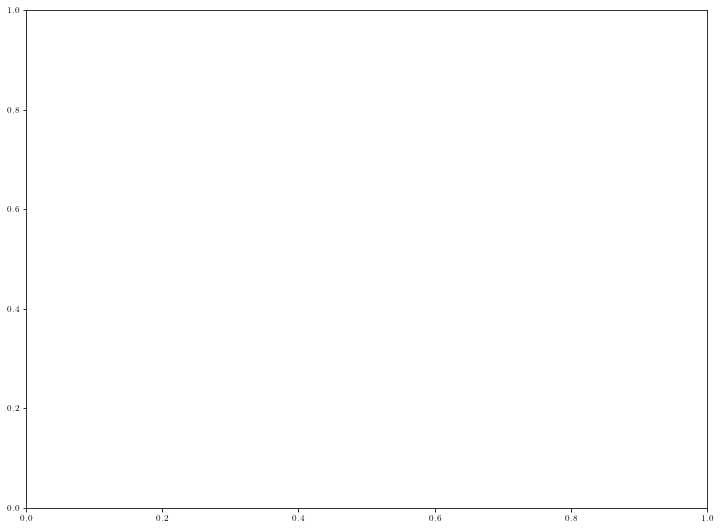

In [54]:
Nt = 4500 # Number of iterations
FDUMP = 100

for it in tqdm(range(Nt+1)):
# for it in tqdm(range(501,1501)):

    if ((it % FDUMP) == 0):
        # plot_fields_unfolded(idump, "Br", 1.0)
        plot_fields_unfolded(idump, "Br", "Br", 0.5)
        idump += 1
    
    for p in range(6):
        contra_to_cov_E(p)

#     getETripleN2("form", Sphere.A, Sphere.N)
#     getETripleN2("form", Sphere.D, Sphere.A)
#     getETripleN2("form", Sphere.N, Sphere.D)
#     getETripleN("form", Sphere.A, Sphere.D) 
#     getETripleN("form", Sphere.N, Sphere.A) 
#     getETripleN("form", Sphere.D, Sphere.N) 

#     for i in range(n_zeros):
#         p0, p1 = index_row[i], index_col[i]
#         communicate_E_patch_covE(p0, p1)       

    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        fillHALO_E_patch_cov(p0, p1)

    correctHaloPoint()
        
    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        communicate_E_patch_cov(p0, p1)

    update_poles()

    for p in range(6):
        push_B(it, p, dt)

#     for i in range(n_zeros):
#         p0, p1 = index_row[i], index_col[i]
#         communicate_B_patch_contraE(p0, p1)

    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        communicate_B_patch_contra(p0, p1)

    for p in range(6):
        contra_to_cov_B(p)

#     for i in range(n_zeros):
#         p0, p1 = index_row[i], index_col[i]
#         communicate_B_patch_covE(p0, p1)
        
    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        communicate_B_patch_cov(p0, p1)

    for p in range(6):
        push_E(it, p, dt)

###### PENALTY TERMS
    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        push_E_penalty(it, p0, p1, dt)

#     getETripleN2("vect", Sphere.A, Sphere.N)
#     getETripleN2("vect", Sphere.D, Sphere.A)
#     getETripleN2("vect", Sphere.N, Sphere.D)
#     getETripleN("vect", Sphere.A, Sphere.D) 
#     getETripleN("vect", Sphere.N, Sphere.A) 
#     getETripleN("vect", Sphere.D, Sphere.N) 

#     for i in range(n_zeros):
#         p0, p1 = index_row[i], index_col[i]
#         communicate_E_patch_contraE(p0, p1)
        
    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        fillHALO_E_patch_contra(p0, p1)
        
    correctHaloPoint()
        
    for i in range(n_zeros):
        p0, p1 = index_row[i], index_col[i]
        communicate_E_patch_contra(p0, p1)
        
    if(it%10==0):
        for p in range(6):
            getDivB(p)
            getE(p)
        maxdivarray.append(N.max(N.abs(Phi)))
        for p in range(6):
            Phi[p, :, :] *= sqrt_det_g[:, :, 3]*dxi*deta
            En[p, :, :] *= dxi*deta
            EnE1[p, :, :] *= dxi*deta
        divarray.append(N.sum(Phi))
        enarray1.append(N.sum(En))
        enarray2.append(N.sum(EnE1))
        DIFF1 = N.sum(N.abs(EnE1[Sphere.A, Nxi + NG, NG:Nxi+NG]-EnE1[Sphere.B, NG, NG:Nxi+NG]))
        DIFF2 = N.sum(N.abs(N.flip(EnE1[Sphere.N, NG, NG+1:Nxi+NG])-EnE1[Sphere.A, NG+1:Nxi+NG, Nxi + NG]))
        diffenarray1.append(DIFF1)
        diffenarray2.append(DIFF2)

#         plot_fields_sphere(it, "Er", 2, 0.1)
        
#     if(it%20==0):   
#         plot_fields_unfolded(it, "Er", "Er", 0.1)

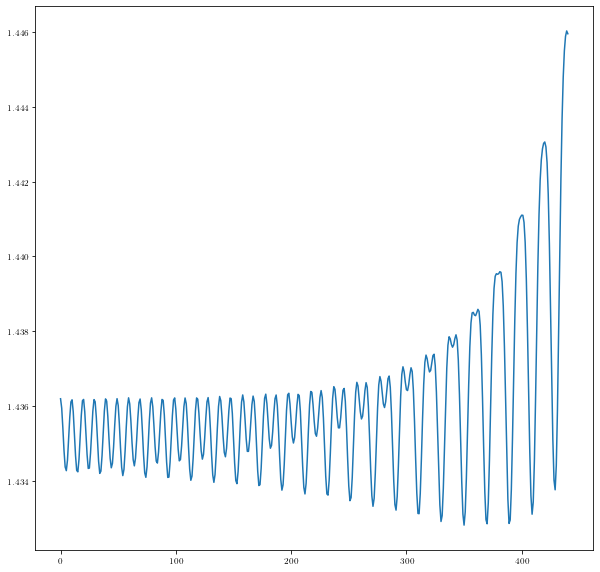

In [55]:
fig = P.figure(0, figsize = (10,10), facecolor='w')
plt.plot((N.array(enarray1))[10:])
# plt.ylim([0.05,0.07])
# plt.yscale('log')
plt.show()

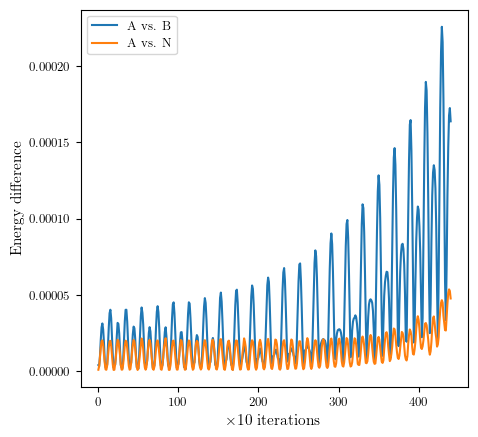

In [56]:
fig = P.figure(0, figsize = (5,5), dpi = 100, facecolor='w')
plt.plot((N.array(diffenarray1))[10:], label = 'A vs. B')
plt.plot((N.array(diffenarray2))[10:], label = 'A vs. N')
# plt.ylim([0.05,0.07])
# plt.yscale('log')
plt.xlabel(r'$\times 10$ iterations')
plt.ylabel(r'Energy difference')
plt.legend()
plt.show()
